In [ ]:
!pip install vaderSentiment
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
tweet = pd.read_excel('data/tweet.xlsx')
reddit = pd.read_excel('data/reddit.xlsx')

def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield.
    Returns scores and original dataframe.'''

    analyzer = SentimentIntensityAnalyzer()

    print('Estimating polarity scores for %d cases.' % len(df))
    sentiment = df[textfield].astype('str').apply(analyzer.polarity_scores)

    # convert to dataframe
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')

    # merge dataframes
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

In [ ]:
tweet_vaderized = vaderize(tweet, 'full_text')
reddit_vaderized = vaderize(reddit, 'body')
tweet_vaderized.to_excel('sentitweet.xlsx', index=True)
reddit_vaderized.to_excel('sentireddit.xlsx', index=True)

In [2]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# !pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

tweet_vaderized = pd.read_excel('data/sentitweet.xlsx')
reddit_vaderized = pd.read_excel('data/sentireddit.xlsx')

In [164]:
startDate = pd.to_datetime('20160301')
endDate = pd.to_datetime('20161221')

i_hour = pd.date_range(start=startDate, end=endDate,freq='D')
tweet_senti = tweet_vaderized.resample('D', on='dtime').mean().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
redditmidsum = reddit_vaderized.resample('D', on='time').sum().reindex(i_hour).fillna(0)
redditmidsum['sentivader'] = (redditmidsum.vaderscore / redditmidsum.scoren).fillna(0)
reddit_senti =  redditmidsum.loc[:,['sentivader']]

tweet_poscount = tweet_vaderized[tweet_vaderized.vader_compound>=0.05].resample('D', on='dtime').count().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
tweet_negcount = tweet_vaderized[tweet_vaderized.vader_compound<=-0.05].resample('D', on='dtime').count().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
reddit_poscount = reddit_vaderized[reddit_vaderized.vadern>=0.05].resample('D', on='time').sum().reindex(i_hour).scoren
reddit_negcount = reddit_vaderized[reddit_vaderized.vadern<=-0.05].resample('D', on='time').sum().reindex(i_hour).scoren

senti = pd.concat([tweet_senti, reddit_senti, tweet_poscount, tweet_negcount, reddit_poscount, reddit_negcount], axis=1)
senti.columns = ['tweet_senti', 'reddit_senti', 'tweet_poscount', 'tweet_negcount', 'reddit_poscount', 'reddit_negcount']
senti = senti.fillna(0)

senti['tweet_posper'] = (senti['tweet_poscount']/(senti['tweet_poscount']+senti['tweet_negcount'])).fillna(0.5)
senti['reddit_posper'] = (senti['reddit_poscount']/(senti['reddit_poscount']+senti['reddit_negcount'])).fillna(0.5)

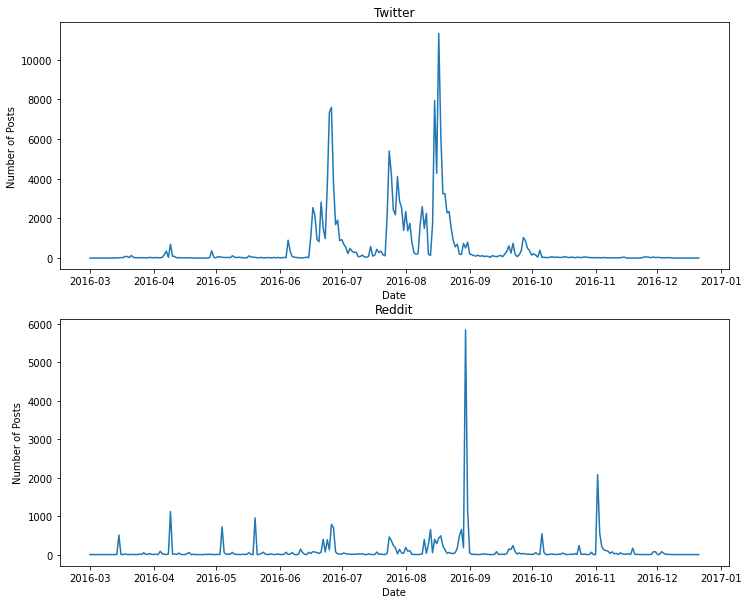

In [167]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(senti['tweet_count'])
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.title('Twitter')
plt.subplot(212)
plt.plot(senti['reddit_count1'])
plt.xlabel("Date")
plt.ylabel("Number of Posts")

plt.title('Reddit')
plt.show()

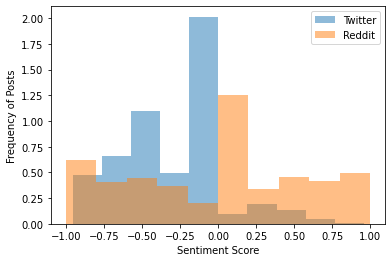

In [121]:
#plt.figure(figsize=(6, 3))
#plt.title('The Sentiment Score for Twitter&Reddit')
tweet_vaderized['vader_compound'].plot(kind='hist', density=True,  alpha=0.5, label='Twitter') #color = 'lightblue', 
reddit_vaderized['vadern'].plot(kind='hist',density=True, alpha=0.5, label='Reddit') #color = 'lightcoral',
plt.legend()
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency of Posts")
plt.show()

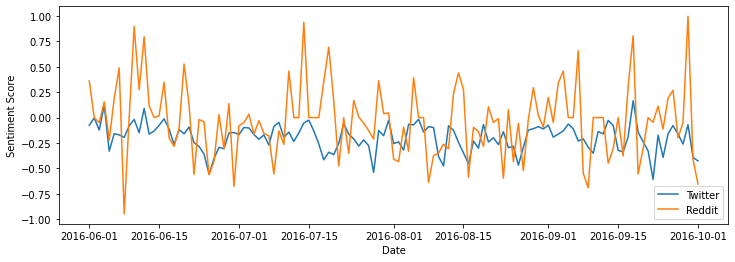

In [122]:
plt.figure(figsize=(12, 4))
plt.plot(senti.tweet_senti,label='Twitter')
plt.plot(senti.reddit_senti,label='Reddit')
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
#plt.title('Sentiment Score')

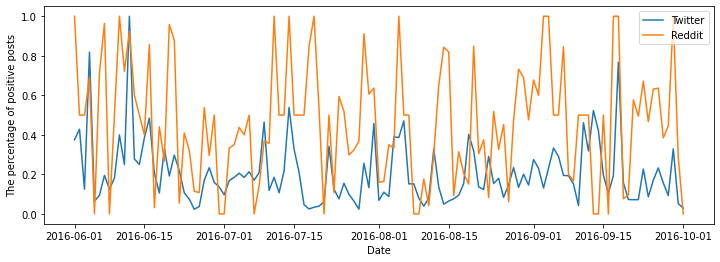

In [150]:
plt.figure(figsize=(12, 4))
plt.plot(senti.tweet_posper,label='Twitter')
plt.plot(senti.reddit_posper,label='Reddit')
plt.xlabel("Date")
plt.ylabel("The percentage of positive posts")
plt.legend()